<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Đừng-Bỏ-hết-Trứng-vào-Một-Giỏ" data-toc-modified-id="Đừng-Bỏ-hết-Trứng-vào-Một-Giỏ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Đừng Bỏ hết Trứng vào Một Giỏ</a></span></li><li><span><a href="#Ước Lượng Mạnh Hai Lần" data-toc-modified-id="Ước Lượng Mạnh Hai Lần-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ước Lượng Mạnh Hai Lần</a></span></li><li><span><a href="#Ý-tưởng-chủ-đạo" data-toc-modified-id="Ý-tưởng-chủ-đạo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ý tưởng chủ đạo</a></span></li><li><span><a href="#Tài-liệu-tham-khảo" data-toc-modified-id="Tài-liệu-tham-khảo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tài liệu tham khảo</a></span></li></ul></div>

## Đừng Bỏ hết Trứng vào Một Giỏ
Chúng ta đã học cách sử dụng hồi quy tuyến tính và điểm xu hướng theo trọng số để ước lượng \\(E[Y|Y=1] - E[Y|Y=0] | X\\). Nhưng chúng ta nên dùng phương thức nào và khi nào? Khi còn nghi ngờ, hãy dùng cả hai!  Ước Lượng Mạnh Hai Lần là cách kết hợp điểm xu hướng và hồi quy tuyến tính để bạn không phải lệ thuộc vào một phương thức đơn lẻ nào. 

Để xem phương thức này hoạt động như thế nào, hãy cùng xem xét thí nghiệm tư duy. Đây là một nghiên cứu đối chứng ngẫu nhiên ở các trường công lập của Mĩ nhằm tìm hiểu tác động của tư duy cầu tiến. (Tư duy cầu tiến là niềm tin cho rằng trí tuệ có thể phát triển theo thời gian cùng với việc làm việc chăm chỉ, sử dụng chiến lược thông minh và giúp đỡ người khác khi cần thiết. Nó đối lập với niềm tin cho rằng trí tuệ là phẩm chất cố định sẵn có khi sinh ra). Các học sinh được tham gia một xê-mi-na để tiếp nhận tư duy cầu tiến. Sau đó, họ theo dõi lúc học sinh nhập học đại học để xem kết quả học tập của các học sinh này. Kết quả được đo dưới dạng chuẩn hóa. Dữ liệu thực tế của nghiên cứu này không được công bố rộng rãi để bảo vệ quyền riêng tư của học sinh. Tuy nhiên chúng ta có dữ liệu mô phỏng với các thuộc tính thống kê tương tự từ [Athey và Wager](https://arxiv.org/pdf/1902.07409.pdf), vì thế chúng ta sẽ sử dụng dữ liệu này để thay thế.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Mặc dù nghiên cứu đã được ngẫu nhiên hóa, dữ liệu trong trường hợp này có vẻ chưa hoàn toàn loại trừ nhiễu. Một lí do có thể là biến can thiệp được đo bằng việc học sinh tham gia xê-mi-na. Mặc dù cơ hội được tham gia là ngẫu nhiên, việc tham dự không hoàn toàn như vậy. Ở đây chúng ta gặp phải việc không tuân thủ. Một bằng chứng là kì vọng của sự thành công của học sinh tương quan với việc tham dự xê-mi-na. Các sinh viên tự đánh giá cao kì vọng thành công của mình có nhiều khả năng tham gia xê-mi-na tư duy cầu tiến hơn.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Vì chúng ta sẽ sử dụng các phương pháp hồi quy (hồi quy tuyến tính và hồi quy lô-gít), chúng ta cần chuyển đổi các biến phân loại thành các biến giả.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# dataset without categorical converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Chúng ta bây giờ đã sẵn sàng để hiểu cách ước lượng mạnh hai lần hoạt động.

## Ước Lượng Mạnh Hai Lần

![img](./data/img/doubly-robust/double.png)

Thay vì trình bày cách tính kết quả ước lượng, trước hết tôi sẽ chỉ cho bạn công thức ước lượng và sau đó giải thích tại sao nó rất ngầu.

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

trong đó \\(\hat{P}(x)\\) là ước lượng điểm xu hướng ( ví dụ sử dụng hồi quy lô-gít), \\(\hat{\mu_1}(x)\\) là ước lượng của \\(E[Y|X, T=1]\\) (ví dụ sử dụng hồi quy tuyến tính), và \\(\hat{\mu_1}(x)\\) là ước lượng của \\(E[Y|X, T=0]\\). Như bạn có thể đoán, phần tử đầu tiên của mô hình ước lượng mạnh hai lần  ước lượng \\(E[Y_1]\\) và phần tử thứ hai ước lượng \\(E[Y_0]\\). Hãy cùng xem xét phần thứ nhất, vì tất cả nguyên lý tương tự cũng áp dụng cho phần thứ hai.

Nhưng trước hết hãy nhìn vào số liệu thực tế.

In [5]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822142018466255

Mô hình ước lượng mạnh hai lần nói rằng chúng ta nên kì vọng các cá nhân tham gia xê-mi-na cầu tiến đạt kết quả học tập cao hơn nhóm đối chứng khoảng 0.388 độ lệch chuẩn. Một lần nữa, chúng ta có thể dùng bootstrap để xây dựng các khoảng tin cậy.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (ates.mean() - 1.96*ates.std(), ates.mean() + 1.96*ates.std()))

ATE 95% CI: (0.35305873798504617, 0.4216501839457554)


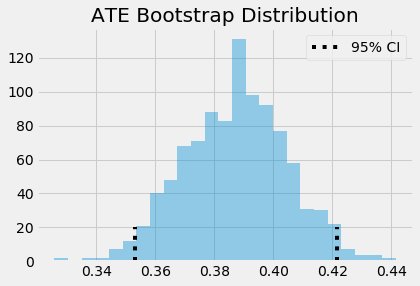

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(ates.mean()-1.96*ates.std(), 0, 20, linestyles="dotted")
plt.vlines(ates.mean()+1.96*ates.std(), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

Bây giờ, hãy cùng xem tại sao mô hình ước lượng mạnh hai lần tuyệt đến như vậy. Nó được gọi là mạnh hai lần vì nó chỉ cần một trong hai mô hình, \\(\hat{P}(x)\\) hoặc \\(\hat{\mu}(x)\\), được đặc tả đúng. Để thấy điều này, hãy nhìn kĩ vào phần tử thứ nhất ước lượng \\(E[Y_1]\\).

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

Trước hết, giả sử \\(\hat{\mu_1}(x)\\) chính xác. Nếu mô hình điểm xu hướng sai, chúng ta cũng không cần lo lắng. Vì nếu \\(\hat{\mu_1}(x)\\) chính xác, thì \\(E[T_i(Y_i - \hat{\mu_1}(X_i))]=0\\). Đó là vì phép nhân với \\(T_i\\) chỉ lựa chọn nhóm can thiệp và phần dư của \\(\hat{\mu_1}\\) đối với nhóm can thiệp, theo định nghĩa, có kì vọng bằng 0. Điều này khiến cả cụm có thể giản ước thành  \\(\hat{\mu_1}(X_i)\\), ước lượng chính xác của \\(E[Y_1]\\) theo giả thiết. Vì thế, khi mô hình ước lượng \\(\hat{\mu_1}(X_i)\\) được đặc tả chính xác, nó loại trừ yêu cầu đặc tả chính xác mô hình điểm xu hướng. Chúng ta có thể áp dụng suy luận tương tự cho mô hình ước lượng \\(E[Y_0]\\). 

Nhưng hãy đừng dễ dàng tin lời tôi. Hãy code để kiểm chứng! Trong mô hình ước lượng sau, tôi đã thay thế hồi quy lô-gít dùng để ước lượng điểm xu hướng bằng một biến ngẫu nhiên phân phối đều nhận giá trị từ 0.1 to 0.9 (Tôi không muốn dùng các trọng số quá nhỏ làm suy yếu phương sai của  điểm xu hướng). Vì biến được khởi tạo ngẫu nhiên, nó khó có thể là một mô hình điểm xu hướng tốt, nhưng chúng ta sẽ thấy mô hình ước lượng mạnh hai lần sẽ vẫn cho một ước lượng khá gần với điểm xu hướng ước lượng bởi hồi quy lô-gít.

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.3796793111749784

Nếu sử dụng phương pháp bootstrap, chúng ta có thể thấy phương sai hơi nhỏ hơn khi sử dụng điểm xu hướng ước lượng bởi hồi quy lô-gít.

In [14]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [15]:
print(f"ATE 95% CI:", (wrong_ps.mean() - 1.96*wrong_ps.std(), wrong_ps.mean() + 1.96*wrong_ps.std()))

ATE 95% CI: (0.3398718751903932, 0.432648947038787)


Khoảng tin cậy này chứa giá trị của mô hình xu hướng sai nhưng kết quả đầu ra vẫn chính xác. Trong trường hợp còn lại thì sao? Hãy cùng nhìn lại phần tử thứ nhất của mô hình ước lượng, nhưng hãy sắp xếp lại một số phần tử trước

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

Bây giờ, giả sử điểm xu hướng \\(\hat{P}(X_i)\\) được đặc tả chính xác. Trong trường hợp này, \\(E[T_i - \hat{P}(X_i)]=0\\), tiêu giảm phần tử phụ thuộc vào \\(\hat{\mu_1}(X_i)\\). Điều này làm mô hình ước lượng mạnh hai lần tiêu giảm thành mô hình ước lượng điểm xu hướng theo trọng số \\(\frac{T_iY_i}{\hat{P}(X_i)}\\),  và chính xác theo giả định. Vì thế ngay cả khi \\(\hat{\mu_1}(X_i)\\) sai, mô hình ước lượng sẽ vẫn chính xác, miễn là điểm xu hướng được đặc tả chính xác.

Một lần nữa, nếu bạn tin vào code hơn công thức, đây là các kiểm chứng thực tế. Trong đoạn code dưới đây, chúng tôi đã thay thế cả hai mô hình hồi quy bằng một biến ngẫu nhiên phân phối thường. Vì thế, không cần phải nghi ngờ \\(\hat{\mu}(X_i)\\) khó có thể được đặc tả đúng. Tuy nhiên, chúng ta sẽ thấy mô hình ước lượng mạnh hai lần vẫn có thể cho  \\(\hat{ATE}\\) tương tự, khoảng 0.38 như chúng ta đã thấy trên đây.

In [16]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [17]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.3981093487821127

Một lần nữa, chúng ta có thể sử dụng bootstrap và thấy phương sai chỉ hơi lớn hơn một chút.

In [19]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [20]:
print(f"ATE 95% CI:", (wrong_mux.mean() - 1.96*wrong_mux.std(), wrong_mux.mean() + 1.96*wrong_mux.std()))

ATE 95% CI: (0.34063210554090934, 0.43426789421365247)


Trong thực tế, chúng ta chẳng bao giờ có điểm xu hướng hoặc mô hình kết quả chính xác 100%. Chúng sẽ đều sai, nhưng sai theo những các khác nhau. Ước lượng mạnh hai lần có thể kết hợp 2 mô hình sai để làm chúng ít sai hơn. 

## Ý tưởng chủ đạo
Ở đây, chúng ta đã xem xét một phương thức đơn giản để kết hợp hồi quy tuyến tính với điểm xu hướng để thu được mô hình ước lượng mạnh hai lần. Tên gọi này xuất phát từ việc nó chỉ yêu cầu một trong hai mô hình đúng. Nếu mô hình điểm xu hướng đúng, chúng ta sẽ có thể xác định chính xác tác động nhân quả ngay cả khi mô hình kết quả sai. Mặt khác, nếu mô hình kết quả đúng, chúng ta cũng có thể xác định tác động nhân quả ngay cả khi mô hình điểm xu hướng sai.

## Tài liệu tham khảo

Tôi muốn dành loạt bài viết này để vinh danh Joshua Angrist, Alberto Abadie and Christopher Walters vì khóa học Kinh tế lượng tuyệt cú mèo của họ. Phần lớn ý tưởng trong loạt bài này được lấy từ các bài giảng của họ được tổ chức bởi Hiệp hội Kinh tế Mĩ.  Theo dõi các bài giảng này là những gì tôi làm trong suốt năm 2020 khó nhằn.
* [Kinh tế lượng với dữ liệu chéo](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Luyện chưởng Kinh tế lượng Gần như Vô hại](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Tôi cũng muốn giới thiệu cuốn sách lý thú của Angrist. Chúng cho tôi thấy Kinh tế lượng, hoặc 'Lượng theo cách họ gọi không chỉ vô cùng hữu ích mà còn rất vui.

* [Kinh tế lượng Gần như Vô hại](https://www.mostlyharmlesseconometrics.com/)
* [Luyện chưởng 'Lượng](https://www.masteringmetrics.com/)

Tài liệu tham khảo cuối cùng của tôi là cuốn sách của Miguel Hernan and Jamie Robins. Nó là người bạn đồng hành tin cậy với tôi khi trả lời những câu hỏi nhân quả khó nhằn.

* [Sách Suy Luận Nhân Quả](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Dữ liệu chúng tôi sử dụng được lấy từ bài báo [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), bởi Susan Athey and Stefan Wager. 

# Bảng Thuật ngữ 
| Thuật ngữ | Tiếng Anh |
| --- | --- | 
|biến can thiệp|treatment variable| 
|biến giả|dummy, dummy variable| 
|biến ngẫu nhiên phân phối thường|random normal variable| 
|biến ngẫu nhiên phân phối đều|random uniform variable| 
|biến phân loại|categorical variable| 
|bootstrap|bootstrap| 
|code|code| 
|hồi quy lô-gít|logistic regression| 
|hồi quy tuyến tính|linear regression| 
|khoảng tin cậy|confidence interval| 
|kinh tế lượng|econometrics| 
|mô hình|model| 
|mô hình hồi quy|regression model| 
|mô hình kết quả|outcome model| 
|mô hình xu hướng|propensity model| 
|mô hình điểm xu hướng|propensity score model| 
|mô hình ước lượng|estimator| 
|mô hình ước lượng mạnh hai lần|doubly robust estimator| 
|mô hình ước lượng điểm xu hướng theo trọng số|propensity score weighting estimator| 
|mạnh hai lần|doubly robust| 
|phương pháp hồi quy|regression method| 
|phương sai|variance| 
|suy luận nhân quả|causal inference, causal reasoning| 
|điểm xu hướng|propensity score| 
|điểm xu hướng theo trọng số|propensity score weighting| 
|đặc tả|specified, specify| 
|độ lệch chuẩn|standard deviation| 
|ước lượng mạnh hai lần|doubly robust estimation| 
